This notebook reproduces Appendix A of Ginolin+24a and its associated figures. It shows that when looking at a simple line fitting problem (here parametrised as SN Ia standardisation), errors on the x-axis lead to :
- A bias on the correlation coefficient when using a simple liokelihood to fit for an affine relation.
- In the case of a x variable distribiuted like SN colours, the corrected y-axis values exhibit a typical upwards tilt of the corrected y-axis values at the low x-end, even when corrected with the true correlation coefficient (here $\beta$).

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, rv_discrete
import sncolor # Available at https://github.com/mginolin/sncolor
from iminuit import cost, Minuit
from iminuit.cost import LeastSquares
import jax.numpy as jnp
import pandas
import standax

In [2]:
def get_mean_std_binned(res, param, bins):
    means = []
    stdev = []
    center_bins = []
    len_bins = []
    for i in range (len(bins)-1):
        mask = (param < bins[i+1]) & (param > bins[i])
        means.append(np.mean(res[mask]))
        stdev.append(np.std(res[mask], ddof=1))
        center_bins.append(np.mean(param[mask]))
        len_bins.append(len(res[mask]))
    return (means, stdev, center_bins, len_bins)

def get_loglikelihood(res, c, sigma_res, sigma_c):
    def f(beta, const):
        return -np.nansum(np.log(norm.pdf(res-beta*c, loc=const, scale=np.sqrt(sigma_res**2+(beta*sigma_c)**2))))
    return f

# Toy colour distribution

In [3]:
xc = np.linspace(-2, 2, 4000)
prob = sncolor.fit_function_tot(xc, 0.159, -0.086, 0.0436) # SN colour distribution from ZTF DR2
color_distrib = rv_discrete(name='color_distrib', values=(xc, prob/np.sum(prob)))

In [4]:
c = color_distrib.rvs(size=1000)

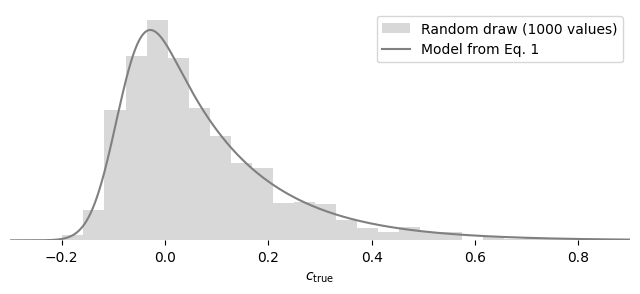

In [5]:
# Figure A.1

plt.figure(figsize=(8, 3))

plt.hist(c, density=True, bins=30, color='grey', alpha=0.3, label='Random draw (1000 values)')
plt.plot(xc, prob, label='Model from Eq. 1', color='Grey')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
plt.xlabel(r'$c_\mathrm{true}$')
plt.legend()
plt.xlim(-0.3, 0.9)

plt.show()

# Standardisation

In [6]:
beta_true = 3.15
const_true = 0

c_err = 0.035   # Typical error on SN colour in the ZTF DR2
mag_err = 0.04  # Typical error on SN magnitude in the ZTF DR2

In [7]:
res = beta_true*c+const_true
c_noisy = c + norm.rvs(0, c_err, size=len(c))
res_noisy = res + norm.rvs(0, mag_err, size=len(res))
res_corr = res_noisy-(beta_true*c_noisy+const_true)
red_corr_true = res_noisy - (beta_true*c+const_true)

### Fitting with loglikelihood method and true colours

In [8]:
m_res_true_c = Minuit(get_loglikelihood(res_noisy, c, mag_err, 0), beta=3.15, const=0)
m_res_true_c.errordef = Minuit.LIKELIHOOD
m_res_true_c.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1793                      │              Nfcn = 31               │
│ EDM = 8.92e-24 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ beta  │   3.155   │   0.008   │            │            │         │         │       │
│ 1 │ const │  -0.0000  │  0.0014   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │     beta    const │
├───────┼───────────────────┤
│  beta │ 6.62e-05  -4.4e-6 │
│ const │  -4.4e-6 1.89e-06 │
└───────┴───────────────────┘

### Fiting with loglikelihood method and noisy colours

In [9]:
m_res = Minuit(get_loglikelihood(res_noisy, c_noisy, mag_err, c_err), beta=3.15, const=0)
m_res.errordef = Minuit.LIKELIHOOD
m_res.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -744.1                     │              Nfcn = 31               │
│ EDM = 1.58e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ beta  │   3.027   │   0.022   │            │            │         │         │       │
│ 1 │ const │   0.012   │   0.004   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────┐
│       │      beta     const │
├───────┼─────────────────────┤
│  beta │  0.000472 -0.031e-3 │
│ const │ -0.031e-3  1.48e-05 │
└───────┴─────────────────────┘

### Fitting with standax and the true colours

In [10]:
fit_data = pandas.DataFrame({'mag':res_noisy, 'c':c, 'c_err':1e-6*np.ones(len(c)),
        'mag_err':mag_err*np.ones(len(c)), 'x1':np.zeros(len(c)), 'x1_err':np.ones(len(c))*1e-6,
        'cov_c_mag':np.zeros(len(c))*1., 'cov_x1_mag':np.zeros(len(c))*1., 'cov_x1_c':np.zeros(len(c))*1.})

In [11]:
init = {"coefs": jnp.asarray([3.15, 0], dtype="float32")}
this = standax.standardisation.Standardize.from_data(fit_data, xkeys=["c", "x1"], ykey="mag", model='linear',
                                                      lmda=1e4)
(best_params, sigmaint, loss), mcmc = this.fit(init, sigmaint=0, nfetch=0, num_samples=1000, verbose=False)

In [12]:
chain_beta = mcmc.get_samples()['coefs'][:,0]
beta_true_c_err = np.sqrt(np.sum((chain_beta-best_params['coefs'][0])**2)/len(chain_beta))
beta_true_c = best_params['coefs'][0]
const_true_c = best_params['offset']

In [13]:
print(beta_true_c, beta_true_c_err)

3.1554096 0.011569442


### Fitting with standax and the noisy colours

In [14]:
fit_data = pandas.DataFrame({'mag':res_noisy, 'c':c_noisy, 'c_err':c_err*np.ones(len(c)),
        'mag_err':mag_err*np.ones(len(c)), 'x1':np.zeros(len(c)), 'x1_err':np.ones(len(c))*1e-6,
        'cov_c_mag':np.zeros(len(c))*1., 'cov_x1_mag':np.zeros(len(c))*1., 'cov_x1_c':np.zeros(len(c))*1.})

In [15]:
init = {"coefs": jnp.asarray([3.15, 0], dtype="float32")}
this = standax.standardisation.Standardize.from_data(fit_data, xkeys=["c", "x1"], ykey="mag", model='linear',
                                                      lmda=1e4)
(best_params, sigmaint, loss), mcmc = this.fit(init, sigmaint=0, nfetch=0, num_samples=1000, verbose=False)

In [16]:
chain_beta = mcmc.get_samples()['coefs'][:,0]
beta_err = np.sqrt(np.sum((chain_beta-best_params['coefs'][0])**2)/len(chain_beta))
beta = best_params['coefs'][0]
const = best_params['offset']

In [17]:
print(beta, beta_err)

3.17089 0.011083117


### Plotting

In [18]:
# Computing the corrected residuals

res_likelihood_true = res_noisy-m_res_true_c.values[0]*c-m_res_true_c.values[1]
res_likelihood_noisy = res_noisy-m_res.values[0]*c_noisy-m_res.values[1]
res_standax_true = res_noisy-beta_true_c*c - const_true_c
res_standax_noisy = res_noisy-beta*c_noisy - const
res_true = res_noisy-beta_true*c - const_true
res_noisy_corr = res_noisy-beta_true*c_noisy - const_true

In [19]:
bins = np.linspace(-0.21, 0.3, 15)

xmin = - 0.21
xmax = 0.3
ymin = - 0.4
ymax = 0.5

/opt/anaconda3/envs/G24_tests/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/G24_tests/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


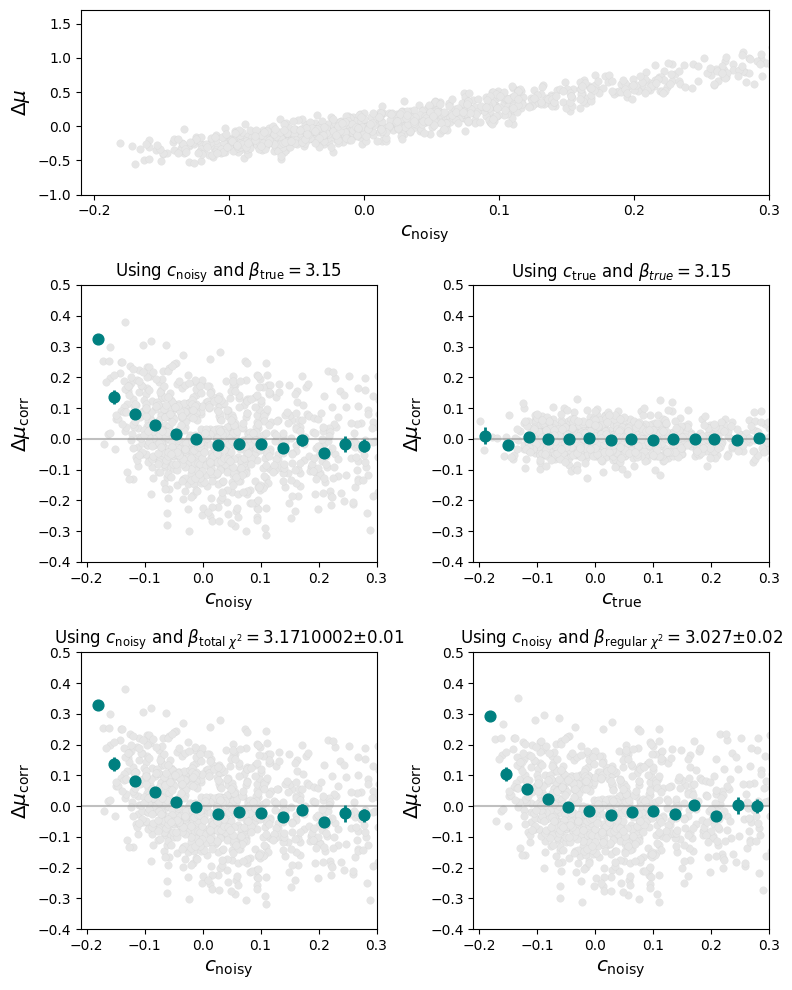

In [20]:
# Figure A.2

fig, axs = plt.subplots(3, 2, figsize=(8, 10), gridspec_kw={'height_ratios': [1, 1.5, 1.5]})

ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)


fig.delaxes(axs[0,0])
fig.delaxes(axs[0,1])


ax0.scatter(c_noisy, res_noisy, marker='o', s=30, facecolors="0.9", edgecolors="0.8", zorder=2, lw=0.1)
ax0.set_xlabel(r'$c_\mathrm{noisy}$', fontsize='x-large')
ax0.set_ylabel(r'$\Delta\mu$', fontsize='x-large')
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([-1, 1.7])

axs[1,0].scatter(c_noisy, res_noisy_corr, marker='o', s=30, facecolors="0.9", edgecolors="0.8", zorder=2, lw=0.1)
means, stdev, center_bins, len_bins = get_mean_std_binned(res_noisy_corr, c_noisy, bins)
axs[1,0].scatter(center_bins, means, marker='o', color='teal', s=60, zorder=10)
axs[1,0].errorbar(center_bins, means, yerr=np.array(stdev)/np.sqrt(np.array(len_bins)),
               fmt='none', markersize=10, color='teal', elinewidth=2, zorder=20)
axs[1,0].axhline(0, c='grey', alpha=0.5)
axs[1,0].set_xlabel(r'$c_\mathrm{noisy}$', fontsize='x-large')
axs[1,0].set_ylabel(r'$\Delta\mu_\mathrm{corr}$', fontsize='x-large')
axs[1,0].set_xlim([xmin, xmax])
axs[1,0].set_ylim([ymin, ymax])
axs[1,0].set_title(r'Using $c_\mathrm{noisy}$ and $\beta_\mathrm{true}=3.15$')

axs[1,1].scatter(c, res_likelihood_true, marker='o', s=30, facecolors="0.9", edgecolors="0.8", zorder=2, lw=0.1)
means, stdev, center_bins, len_bins = get_mean_std_binned(res_likelihood_true, c, bins)
axs[1,1].scatter(center_bins, means, marker='o', color='teal', s=60, zorder=10)
axs[1,1].errorbar(center_bins, means, yerr=np.array(stdev)/np.sqrt(np.array(len_bins)),
               fmt='none', markersize=10, color='teal', elinewidth=2, zorder=20)
axs[1,1].axhline(0, c='grey', alpha=0.5)
axs[1,1].set_xlabel(r'$c_\mathrm{true}$', fontsize='x-large')
axs[1,1].set_ylabel(r'$\Delta\mu_\mathrm{corr}$', fontsize='x-large')
axs[1,1].set_xlim([xmin, xmax])
axs[1,1].set_ylim([ymin, ymax])
axs[1,1].set_title(r'Using $c_\mathrm{true}$ and $\beta_{true}=3.15$')


axs[2,0].scatter(c_noisy, res_standax_noisy, marker='o', s=30, facecolors="0.9", edgecolors="0.8", zorder=2, lw=0.1)
means, stdev, center_bins, len_bins = get_mean_std_binned(res_standax_noisy, c_noisy, bins)
axs[2,0].scatter(center_bins, means, marker='o', color='teal', s=60, zorder=10)
axs[2,0].errorbar(center_bins, means, yerr=np.array(stdev)/np.sqrt(np.array(len_bins)), 
               fmt='none', markersize=10, color='teal', elinewidth=2, zorder=20)
axs[2,0].axhline(0, c='grey', alpha=0.5)
axs[2,0].set_xlabel(r'$c_\mathrm{noisy}$', fontsize='x-large')
axs[2,0].set_ylabel(r'$\Delta\mu_\mathrm{corr}$', fontsize='x-large')
axs[2,0].set_xlim([xmin, xmax])
axs[2,0].set_ylim([ymin, ymax])
axs[2,0].set_title(r'Using $c_\mathrm{noisy}$ and $\beta_{\mathrm{total~}\chi^2}=$'+str(round(beta, ndigits=3))+r'$\pm$'+str(round(beta_err, ndigits=2)))

axs[2,1].scatter(c_noisy, res_likelihood_noisy, marker='o', s=30, facecolors="0.9", edgecolors="0.8", zorder=2, lw=0.1)
means, stdev, center_bins, len_bins = get_mean_std_binned(res_likelihood_noisy, c_noisy, bins)
axs[2,1].scatter(center_bins, means, marker='o', color='teal', s=60, zorder=10)
axs[2,1].errorbar(center_bins, means, yerr=np.array(stdev)/np.sqrt(np.array(len_bins)), 
               fmt='none', markersize=10, color='teal', elinewidth=2, zorder=20)
axs[2,1].axhline(0, c='grey', alpha=0.5)
axs[2,1].set_xlabel(r'$c_\mathrm{noisy}$', fontsize='x-large')
axs[2,1].set_ylabel(r'$\Delta\mu_\mathrm{corr}$', fontsize='x-large')
axs[2,1].set_xlim([xmin, xmax])
axs[2,1].set_ylim([ymin, ymax])
axs[2,1].set_title(r'Using $c_\mathrm{noisy}$ and $\beta_{\mathrm{regular~}\chi^2}=$'+str(round(m_res.values[0], ndigits=3))+r'$\pm$'+str(round(m_res.errors[0], ndigits=2)))

plt.tight_layout()

plt.show()